In [1]:
from default_new import *


Using TensorFlow backend.


shape of encoded (None, 4, 4, 8)
shape of decoded (None, 28, 28, 1)
4.90651438239 norm
4.93280520495 norm
4.91637516322 norm
4.89748164727 norm
4.88391462316 norm
4.86503304385 norm
4.89797481061 norm
4.9285246181 norm
4.89394802266 norm
4.84426020366 norm
(1960, 128) digits
(20, 128) good digits
[  9.99869943e-01   1.89035276e-09   1.57761826e-09   2.97211450e-10
   4.77305795e-09   4.19202161e-06   2.71177760e-05   4.12967211e-06
   9.45067368e-05   8.31552960e-09] preds
0.92906 activation mean
0.223631 activation sd


In [2]:
import numpy.linalg as nla
import scipy.linalg as sla
target=tf.placeholder("float",shape=(10,))

generator = Sequential([decoder,cnn])
generatorPre = Sequential([decoder]+cnn.layers[:-1])
gradients = tf.gradients(generator.output, generator.input,grad_ys=target)
good_mean,good_cov,good_samples=mean_cov(encoded,lower_thresh=.1,upper_thresh=4)

4.90651438239 norm
4.93280520495 norm
4.91637516322 norm
4.89748164727 norm
4.88391462316 norm
4.86503304385 norm
4.89797481061 norm
4.9285246181 norm
4.89394802266 norm
4.84426020366 norm
(1960, 128) digits
(1315, 128) good digits


In [3]:
import time
import numpy.linalg as nla
import numpy.random as nrand

zcov = np.abs(cov).sum(axis=1)==0
zmean = (mean==0)
cov_safe = cov +np.eye(len(zcov))
cho=sla.cho_factor(cov_safe)

def getLL(points):
    centered=(points.reshape(-1,128)-mean[np.newaxis,:])
    return -(centered.T*sla.cho_solve(cho,centered.T)).sum(axis=0)

def getLLgradient(points):
    centered = (points.reshape(-1,128)-mean[np.newaxis,:])
    grads = -sla.cho_solve(cho,centered.T).T
    return grads.reshape(-1,4,4,8)

def getCentered(points):
    centered=(points.reshape(-1,128)-mean[np.newaxis,:])
    return centered


target_array = np.zeros(10)
target_array[0] = 1

def getActivations(arr):
    global generator,target_array
    return (generator.predict(arr)*target_array).sum(axis=1)

def norm(arr):
    for i in range(len(arr.shape)-1):
        arr=nla.norm(arr,axis=-1)
    return arr+1e-8

def normalized(a):
    return a/norm(a)[:,None,None,None]
        
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def optimizeSamples(samples,num_iters=10,step_size=1e-5):
    sess = K.get_session()
    current = samples.copy()
    for i in range(num_iters):
        fd={generator.input:current,K.learning_phase(): 0,target:target_array}
        evaluated_gradients = sess.run(gradients,feed_dict=fd)[0]
        ll_gradients = getLLgradient(current)
        #current-=step_size*nla.norm(evaluated_gradients)
        #current+=step_size*(0*nla.norm(evaluated_gradients)+nla.norm(ll_gradients))
        current+= 1e-2 *evaluated_gradients + 1e-3 * ll_gradients
    return current


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

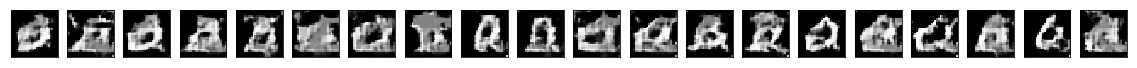

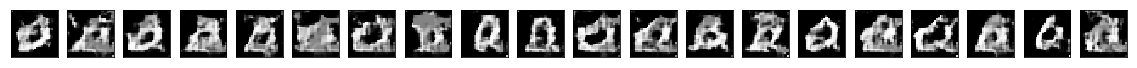

[ 0.24447183  0.29042187  0.53814971  0.83110142  0.57240266  0.13715018
  0.32248291  0.12411045  0.55303407  0.45686221  0.12528957  0.40388846
  0.16911481  0.87471569  0.59218162  0.57925832  0.7615481   0.82443267
  0.13334872  0.17669524  0.35305259  0.8454771   0.19164041  0.22751977
  0.12778743  0.25988606  0.29434732  0.7772615   0.12994304  0.88760197
  0.81186903  0.82102668  0.62631744  0.89848566  0.24706648  0.25529042
  0.81039673  0.13996811  0.12338133  0.13246568  0.43050957  0.86648566
  0.14771602  0.1750579   0.12290062  0.14675084  0.16232824  0.12562941
  0.14704439  0.26470459  0.29017016  0.1212231   0.12384038  0.17539757
  0.12777393  0.89765686  0.2537019   0.64648175  0.13330971  0.48099187
  0.69296288  0.85456121  0.14433576  0.62024218  0.12595029  0.75284588
  0.88592374  0.72273022  0.79031169  0.53415138  0.12887202  0.12459148
  0.5500955   0.42595595  0.82018107  0.46215749  0.19960605  0.16424403
  0.12744272  0.64646703  0.18585768  0.21009834  0

In [5]:
def print_images(decoded_imgs,max_num=20):
    n = min(max_num,len(decoded_imgs))
    for i in range(n):
        if i%20 == 0:
            plt.figure(figsize=(20, 4))
        # display reconstruction
        ax = plt.subplot(2, 20, i %20 + 1 )
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i%20 == 19:
            plt.show()
    plt.show()

def print_codes(codes,max_num=20):
    print_images(decoder.predict(codes.reshape(-1,4,4,8)),max_num)
    
def filterMedActs(samples):
    acts=getActivations(samples)
    return samples[np.logical_and(.12<acts,acts<.9)]

mediums = filterMedActs(good_samples)
opt_samples = optimizeSamples(mediums)
print_images(decoder.predict(mediums))
print_images(decoder.predict(opt_samples))
print(getActivations(mediums))
print(getActivations(opt_samples))
# print(getLL(good_samples))
# print(getLL(opt_samples))


(115, 4, 4, 8)


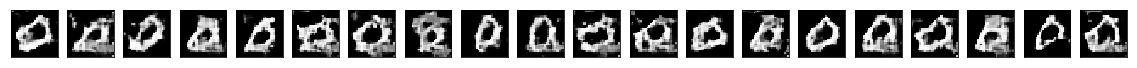

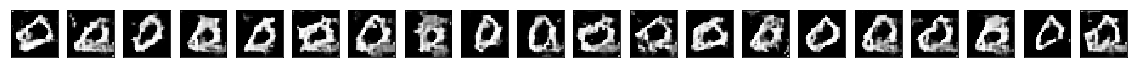

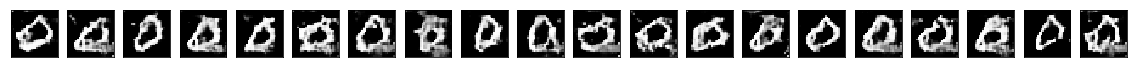

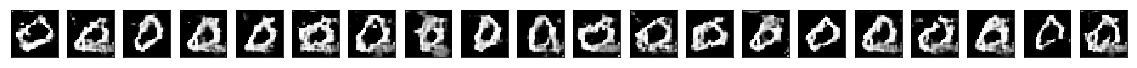

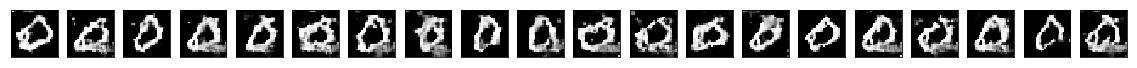

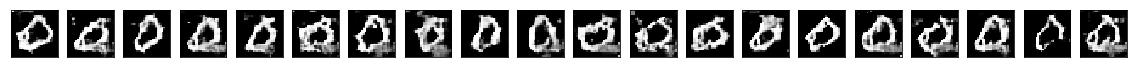

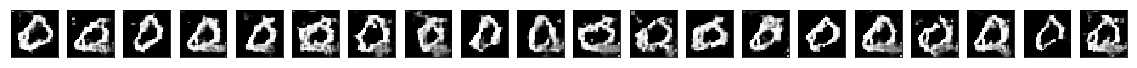

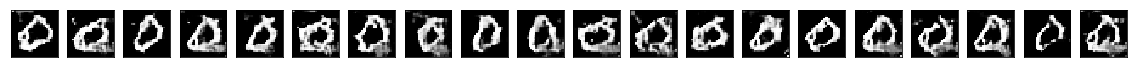

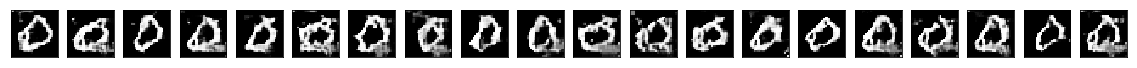

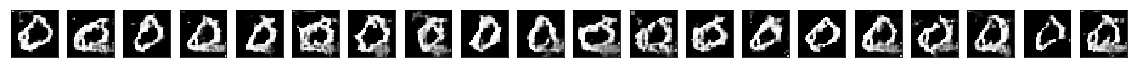

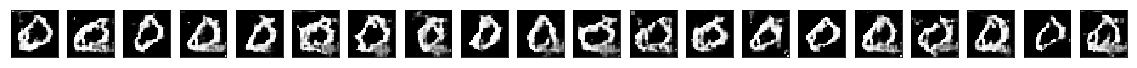

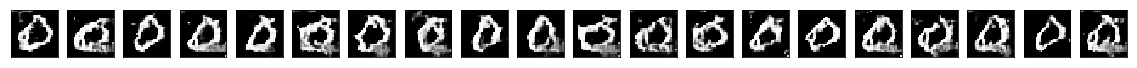

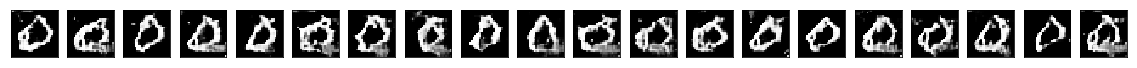

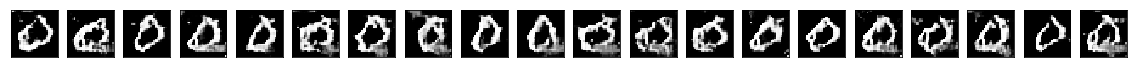

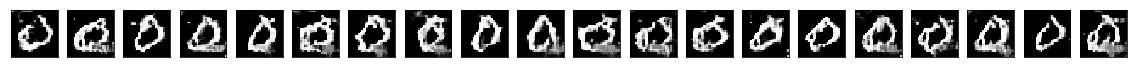

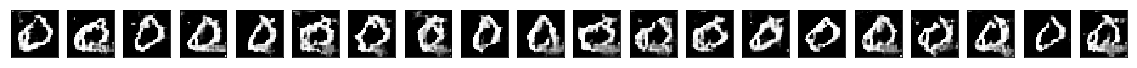

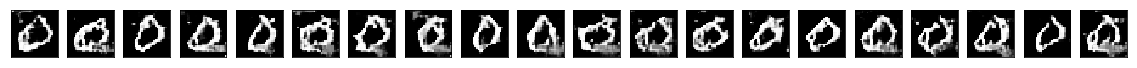

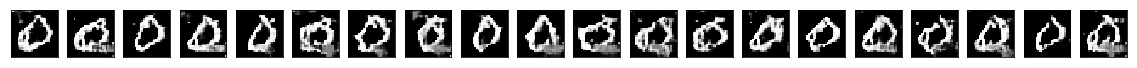

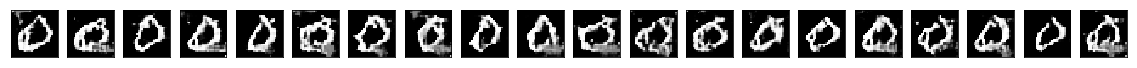

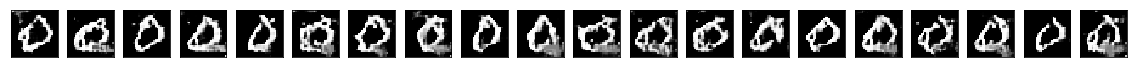

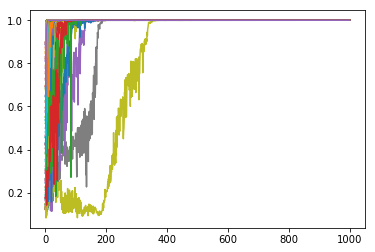

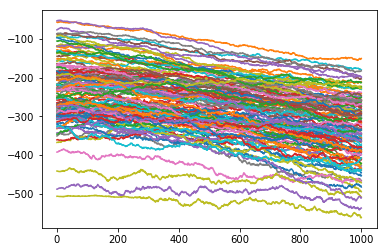

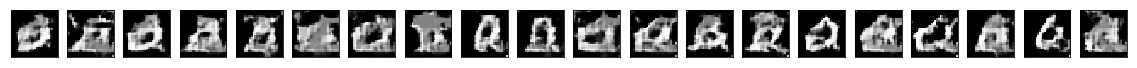

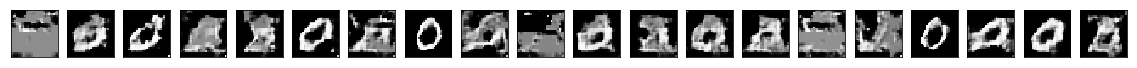

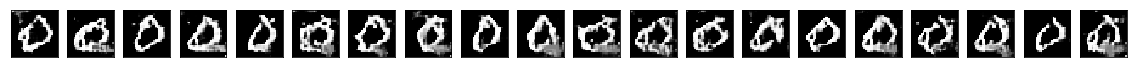

In [6]:
def filterMedActs(samples):
    acts=getActivations(samples)
    return samples[np.logical_and(.12<acts,acts<.9)]

print(filterMedActs(good_samples).shape)
generatorPre = Sequential(decoder.layers+cnn.layers[:-1]+[Activation("linear")])
target=tf.placeholder("float",shape=(None,10,))

def chartSamples(samples,num_iters=1000,num_sub=1,step_size=1e-1):
    step_size/=num_sub
    sess = K.get_session()
    current = samples.copy()
    activation_history = [getActivations(current)]
    ll_history = [getLL(current)]
    target=tf.placeholder("float",shape=(None,10,))
    target_array = np.zeros((samples.shape[0],10))
    target_array[:,0] = 1
    gradients = tf.gradients(generatorPre.output, generatorPre.input,grad_ys=target)
    for i in range(num_iters):
        fd={generatorPre.input:current,K.learning_phase(): 0,target:target_array}
        evaluated_gradients = sess.run(gradients,feed_dict=fd)[0]
        #print(evaluated_gradients)
        ll_gradients = getLLgradient(current)
        #print(i,norm(evaluated_gradients))
        norm_eg=normalized(evaluated_gradients)
        norm_ll=normalized(ll_gradients)
        noise = nrand.normal(size=samples.shape)
        for _ in range(num_sub):
            #current-=step_size*nla.norm(evaluated_gradients)
            #current+=step_size*(0*nla.norm(evaluated_gradients)+nla.norm(ll_gradients))
            #current+=step_size*(nla.norm(ll_gradients))
            #current+=step_size*ll_gradients
            activations = getActivations(current)
            current+=step_size*(1 * norm_eg + .3 * activations[:,None,None,None] * noise + 1e-3 * norm_ll)
            #print(nla.norm(evaluated_gradients,axis=1))
            #current+= step_size * nla.norm(evaluated_gradients)
            activation_history += [activations]
            ll_history +=[getLL(current)]
        
        if (i+1)%50==0:
            print_codes(current)
            pass
            #current = (current + recoder.predict(current))/2
            
    for row in np.array(activation_history).T:
        plt.plot(row)
    plt.show()
    for row in np.array(ll_history).T:
        plt.plot(row)
    plt.show()
    return current
mediums=filterMedActs(good_samples)
medium_opt=chartSamples(mediums)
print_codes(mediums)
print_codes(good_samples)
print_codes(medium_opt)
# #print(getActivations(mediums))
# print(getLL(mediums))
# #print(getActivations(medium_opt))
# print(getLL(medium_opt))

In [7]:
#white_noise = nrand.uniform(size=(10,28,28,1))
#print_codes(encoder.predict(white_noise))
#chartSamples(encoder.predict(white_noise))

In [8]:
%load_ext autoreload
%aimport -default
%autoreload 2


In [9]:
def print_codes(codes,max_num=20):
    print_images(decoder.predict(codes.reshape(-1,4,4,8)),max_num)

target_array = np.zeros(10)
target_array[0] = 1

# def cmaObjective(arr):
#     global generator,generatorPre,target_array
#     return -(generatorPre.predict(arr.reshape(-1,4,4,8))*target_array).sum(axis=1)
# #print(cmaObjective(good_samples[:1].reshape(1,128)))

# from cmaCode import CMAParallel

# from threading import Thread


In [10]:
# results = []
# def cmaOptimize(sample):
#     es = CMAParallel(sample.reshape(128),.5,{'verbose':-3,'maxiter':1000,'popsize':15})
#     es.optimize(cmaObjective)
#     print_codes(sample)
#     print_codes(es.best.x)
#     print(getLL(sample))
#     print(getLL(es.best.x))
#     return es.best.x
# for i in range(0,10):
#     #Thread(target=cmaOptimize,args=(mediums[i],)).start()
#     results+=[(mediums[i],cmaOptimize(mediums[i]))]


In [11]:
# for i in range(2,4):
#     results+=[cmaOptimize(mediums[i])]

In [12]:
def metric(sample, activation_fn, n=200, eps=0.1, percentile = .1):
    #if this is too slow, speed it up by doing it more idiomatically numpy-ly
    sample = sample.reshape(1,4,4,8)
    results = []
    for i in range(n):
        noise = nrand.normal(size=(1,4,4,8), scale=eps)
        noised_sample = sample + noise
        results.append(activation_fn(noised_sample))
    results.sort()
    return results[int(n*percentile)]

In [40]:
for sample in opt_samples[:10]:
    print(metric(sample, getActivations, n=1000, eps=0.01))

[ 0.94958752]
[ 0.96655363]


KeyboardInterrupt: 

In [41]:
# l = []
# for sample in opt_samples[:10]:
#     l.append(metric(sample, getActivations, n=200, eps=0.05))

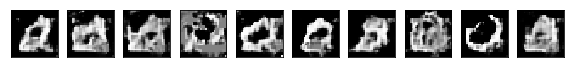

[ 0.82968611  0.55838364  0.17020786  0.154118    0.77401936  0.80307949
  0.44947016  0.21751492  0.82853717  0.80414426]
[ 0.9587568   0.97762942  0.96455574  0.27739453  0.98210287  0.99489141
  0.94541734  0.3028098   0.95525497  0.96701664]
[array([ 0.6429348]), array([ 0.68253309]), array([ 0.36599138]), array([ 0.0537599]), array([ 0.53366518]), array([ 0.78637344]), array([ 0.5202058]), array([ 0.03511853]), array([ 0.4621141]), array([ 0.75533521])]
[array([ 0.80705249]), array([ 0.78014874]), array([ 0.56966364]), array([ 0.11951766]), array([ 0.79940385]), array([ 0.92548835]), array([ 0.70685858]), array([ 0.18370488]), array([ 0.80674338]), array([ 0.86634374])]


In [50]:
#exploring MEDIAN vs 5th percentile vs MIN
#also looking at our metric vs simple activation function.  (all with softmax)
mn = []
for sample in opt_samples[:10]:
    mn.append(metric(sample, getActivations, n=200, eps=0.05, percentile=0))
notmn = []
for sample in opt_samples[:10]:
    notmn.append(metric(sample, getActivations, n=200, eps=0.05, percentile=0.05))

print_codes(opt_samples[:10])
print(getActivations(mediums[:10]))
print(getActivations(opt_samples[:10]))
print(mn)
print(notmn)

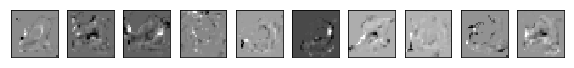

In [13]:
generatorPrePost = Sequential(cnn.layers[:-1])
def getActivations_from_decoded(arr):
    #using this will _not_ perform softmax at the end.
    #(Returns "confidence of zeroness" instead of "confidence of zeroness as opposed to other-digit-ness")
    return (generatorPrePost.predict(arr)*target_array).sum(axis=1)

def metric_img(sample, activation_fn, n=200, eps=0.1, percentile = .1):
    #this metric perturbs img in imgspace as opposed to in latent space
    #if this is too slow, speed it up by doing it more idiomatically numpy-ly
    #decoded_sample = decoder.predict(sample.reshape(1,4,4,8))
    decoded_sample = sample.reshape(1,28,28,1)
    results = []
    for i in range(n):
        noise = nrand.normal(size=(1,28,28,1), scale=eps)
        noised_sample = decoded_sample + noise
        results.append(activation_fn(noised_sample))
    results.sort()
    return results[int(n*percentile)]


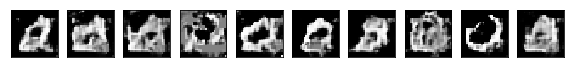

[ 4.88212633  1.41011643  0.38395244  0.16491686  4.1045804   5.85856962
  2.67273617  0.53019696  6.52437019  2.49757528]
[ 5.43755627  3.44352007  4.0715313   0.72550213  5.97397661  8.77630711
  5.29871941  0.86606807  6.92153358  4.00654411]
[array([ 3.79053378]), array([ 2.64094329]), array([ 2.95913053]), array([ 0.42115128]), array([ 4.70558023]), array([ 7.58271933]), array([ 4.13118839]), array([ 0.60444766]), array([ 5.8491683]), array([ 2.45592666])]
[array([ 4.65208912]), array([ 2.85133171]), array([ 3.45728469]), array([ 0.53194493]), array([ 4.99064112]), array([ 8.08834648]), array([ 4.47082806]), array([ 0.66226095]), array([ 6.25669956]), array([ 3.43558478])]
[array([ 5.4316206]), array([ 3.43810821]), array([ 4.07723618]), array([ 0.77212077]), array([ 5.8041544]), array([ 8.921628]), array([ 5.23557281]), array([ 0.92951155]), array([ 6.860044]), array([ 4.15252256])]


In [85]:
#more comparing min, 5th percentile, median
mn = []
for sample in opt_samples[:10]:
    mn.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.05, percentile=0))
notmn = []
for sample in opt_samples[:10]:
    notmn.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.05, percentile=0.05))
median = []
for sample in opt_samples[:10]:
    median.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.05, percentile=0.5))
print_codes(opt_samples[:10])
print(getActivations_from_decoded(decoder.predict(mediums[:10])))
print(getActivations_from_decoded(decoder.predict(opt_samples[:10])))
print(mn)
print(notmn)
print(median)
#[ 0.9587568   0.97762942  0.96455574  0.27739453  0.98210287  0.99489141
#  0.94541734  0.30280977  0.95525497  0.96701664

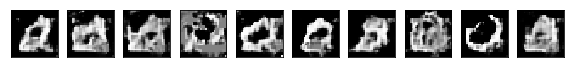

[ 0.82968611  0.55838364  0.17020786  0.154118    0.77401936  0.80307949
  0.44947016  0.21751492  0.82853717  0.80414426]
[ 0.9587568   0.97762942  0.96455574  0.27739453  0.98210287  0.99489141
  0.94541734  0.3028098   0.95525497  0.96701664]
[array([ 5.15798664]), array([ 3.22494721]), array([ 3.7330184]), array([ 0.65458548]), array([ 5.74238253]), array([ 8.38533783]), array([ 5.03928757]), array([ 0.75889921]), array([ 6.69688177]), array([ 3.69545889])]
[array([ 5.28858232]), array([ 3.30151987]), array([ 3.93736124]), array([ 0.67055744]), array([ 5.78745127]), array([ 8.56253052]), array([ 5.12247896]), array([ 0.7996496]), array([ 6.79571056]), array([ 3.83778596])]
[array([ 5.42165709]), array([ 3.44478607]), array([ 4.07361221]), array([ 0.72872603]), array([ 5.95947266]), array([ 8.77966785]), array([ 5.27296305]), array([ 0.86737931]), array([ 6.93502474]), array([ 4.00576067])]


In [86]:
#examining metric when perturbing in IMAGE SPACE instead of latent space
mn = []
for sample in opt_samples[:10]:
    mn.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.01, percentile=0))
notmn = []
for sample in opt_samples[:10]:
    notmn.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.01, percentile=0.05))
median = []
for sample in opt_samples[:10]:
    median.append(metric_img(sample, getActivations_from_decoded, n=200, eps=0.01, percentile=0.5))
print_codes(opt_samples[:10])
print(getActivations(mediums[:10]))
print(getActivations(opt_samples[:10]))
print(mn)
print(notmn)
print(median)
#[ 0.9587568   0.97762942  0.96455574  0.27739453  0.98210287  0.99489141
#  0.94541734  0.30280977  0.95525497  0.96701664

## The subjective way we were adjudicating these metrics were to find ones that didn't really overrate examples 1 and 2 above, since 1 and 2 started off with 0.55 and 0.17 zeroness, before gradient descent optimized them (without, to the human eye, changing them) to 0.977 and 0.964 zeroness.  We wanted example 0 to still be rated decently well, but our metric could hopefully see through examples 1 and 2 for what they originally were.

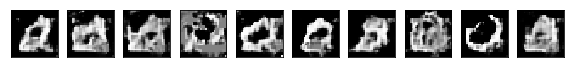

[ 4.88212633  1.41011643  0.38395244  0.16491686  4.1045804   5.85856962
  2.67273617  0.53019696  6.52437019  2.49757528]
[ 5.43755627  3.44352007  4.0715313   0.72550213  5.97397661  8.77630711
  5.29871941  0.86606807  6.92153358  4.00654411]
[array([ 0.84323287]), array([-1.35591066]), array([-1.51488853]), array([-2.56291223]), array([-0.18829517]), array([ 3.16957545]), array([ 0.29401636]), array([-2.70860004]), array([ 3.39781833]), array([ 1.14283752])]
[array([ 3.95281863]), array([ 0.42940271]), array([ 0.72397375]), array([-0.56913793]), array([ 2.20951223]), array([ 6.69300127]), array([ 1.99291348]), array([-0.37891182]), array([ 5.00256014]), array([ 2.40556431])]
[array([ 5.26746702]), array([ 2.12017226]), array([ 2.43794394]), array([ 0.30718461]), array([ 5.02024937]), array([ 8.92690468]), array([ 3.68815064]), array([ 0.6784296]), array([ 6.45190716]), array([ 3.79133821])]


In [169]:
#since the image space metric didn't seem to adequately penalize examples 1 and 2 above, and since 2 was rated higher than 1 afterwards,
#we decided that the metric in latent space was better.
#we also settled on using no softmax in our metric.
def getActivations_no_activation(arr):
    return (generatorPre.predict(arr)*target_array).sum(axis=1)

mn = []
for sample in opt_samples[:10]:
    mn.append(metric(sample, getActivations_no_activation, n=200, eps=0.1, percentile=0))
notmn = []
for sample in opt_samples[:10]:
    notmn.append(metric(sample, getActivations_no_activation, n=200, eps=0.1, percentile=0.1))
median = []
for sample in opt_samples[:10]:
    median.append(metric(sample, getActivations_no_activation, n=200, eps=0.1, percentile=0.5))
print_codes(opt_samples[:10])
print(getActivations_no_activation(mediums[:10]))
print(getActivations_no_activation(opt_samples[:10]))
print(mn)
print(notmn)
print(median)
#[ 0.9587568   0.97762942  0.96455574  0.27739453  0.98210287  0.99489141
#  0.94541734  0.30280977  0.95525497  0.96701664

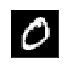

[ 17.12091255]
[ 17.16377831]


In [145]:
#seeing how our imagespace metric does on real mnist zeroes.
print_images(x_train[1].reshape(1,28,28,1))
#the following line prints our metric's score on this zero
print(metric_img(x_train[1].reshape(1,28,28,1), getActivations_from_decoded))
#the following line prints the activation fn on this zero
print(getActivations_from_decoded(x_train[1].reshape(1,28,28,1)))
#as you can see, they are almost identical.  This is good.  A real mnist zero is not an adversarial example, and shouldn't be penalized.

[ 16.18774796  13.66077137  14.76134491  14.38529587  13.06071472
  13.94434071  12.12122822  18.04460526  17.64857864  11.53106594]


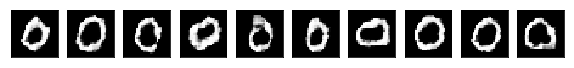

[ 15.53148842]
[ 11.60823822]
[ 14.0349865]
[ 11.51295853]
[ 11.60781956]
[ 11.92347717]
[ 11.47598934]
[ 17.04629707]
[ 16.48246002]
[ 9.84826946]


In [172]:
#seeing how our latent space metric does on real mnist zeroes.
#result: it penalizes each zero by about 1 to 2 points.  (this is because the metric by default returns the 5th percentile 
#of the samples it takes, not the median).  It loses more than the metric in image space because the perturbations
#are more radical here.

zeroez = get_digits(encoded, 0)[:10]
print(getActivations_no_activation(zeroez))


print_codes(zeroez)
for i in zeroez:
    print(metric(i.reshape(1,4,4,8), getActivations_no_activation, ))

In [108]:
#zeroes in medium_opt were the ones resulting from our final gradient ascent optimization.
#they look like zeroes and their activation fn pre-softmax was the variable being optimized for.
#thus, they have extremely high pre-softmax activation functions.
metric(medium_opt[0], getActivations_no_activation)

array([ 30.83478928])

In [142]:
#they lose around 7 points from our metric.  
print(metric(medium_opt[7], getActivations))
print(metric(medium_opt[7], getActivations_no_activation))
print(getActivations_no_activation(medium_opt[7].reshape(1,4,4,8)))

[ 1.]
[ 17.33318901]
[ 24.72913933]


In [141]:
print(metric(medium_opt[8], getActivations))
print(metric(medium_opt[8], getActivations_no_activation))
print(getActivations_no_activation(medium_opt[8].reshape(1,4,4,8)))

[ 1.]
[ 30.00341415]
[ 37.75373459]


### At this point, we realized that we were more or less subjectively looking for a good metric on a variety of intangible factors.  I sat down and thought about how, or if, we could somewhat quantitatively choose a good metric.

### I settled on finding a metric that penalizes fake zeroes more than MNIST zeroes.  Currently, the fake zeroes score around 10 points higher on the classifier pre-softmax than the MNIST zeroes.  So I wanted to find a metric that minimized MEDIAN(fake zero scores) - MEDIAN(MNIST zero scores).

### After running the following grid search through parameters, I concluded that changing the parameters did not affect the result very much.  Consistently the fake zero scores median was around 25 and the real zeroes score median was around 13.

[ 16.18774796  13.66077137  14.76134491  14.38529587  13.06071472
  13.94434071  12.12122822  18.04460526  17.64857864  11.53106594]


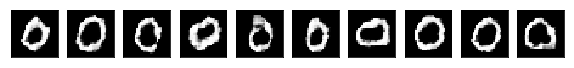

[ 37.69982147  33.34399033  35.24215317  27.61591148  34.491539
  28.97439575  32.7736969   24.72913742  37.7537384   29.8314724 ]


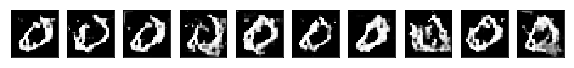

0.01 0
[array([ 15.49844551]), array([ 11.31731987]), array([ 14.08413506]), array([ 11.74239922]), array([ 11.44300461]), array([ 11.77745914]), array([ 11.47041893]), array([ 16.9862175]), array([ 16.49932671]), array([ 10.04657364])]
[array([ 29.79423332]), array([ 26.05109024]), array([ 30.94320107]), array([ 18.19587326]), array([ 26.70422745]), array([ 20.25601768]), array([ 28.90786552]), array([ 17.73673058]), array([ 30.20776176]), array([ 23.93955612])]
25.2736557007 13.0865300179
:(
0.01 0.01
[array([ 15.56830978]), array([ 10.77049828]), array([ 13.91548729]), array([ 11.68322659]), array([ 11.2911377]), array([ 11.71407604]), array([ 11.2409296]), array([ 16.98498726]), array([ 16.42415047]), array([ 9.81434345])]
[array([ 30.61049843]), array([ 27.1055584]), array([ 30.87211609]), array([ 18.06823158]), array([ 26.39673615]), array([ 19.96358109]), array([ 29.34881592]), array([ 17.94049454]), array([ 29.41889954]), array([ 24.16485214])]
25.3889783859 12.9407146454
:(
0.

[array([ 31.19329453]), array([ 26.53097153]), array([ 31.00629807]), array([ 18.63102722]), array([ 26.81965256]), array([ 19.99470711]), array([ 28.4277935]), array([ 17.61606216]), array([ 29.55174637]), array([ 23.93684387])]
25.3708396912 12.9928514481
:(
0.05 0.1
[array([ 15.58347988]), array([ 10.97696209]), array([ 14.15114212]), array([ 11.96586704]), array([ 11.80352783]), array([ 11.86773872]), array([ 11.36182976]), array([ 17.00119972]), array([ 16.44910431]), array([ 9.73139191])]
[array([ 31.15740967]), array([ 26.08541107]), array([ 31.04263115]), array([ 18.77685928]), array([ 26.92336464]), array([ 21.15565109]), array([ 28.48060226]), array([ 17.71691322]), array([ 29.68611526]), array([ 23.75204659])]
25.4777004242 13.0892243385
:(
0.05 0.2
[array([ 15.5454216]), array([ 11.5839529]), array([ 13.95659351]), array([ 11.83602524]), array([ 11.30966091]), array([ 11.69055176]), array([ 11.46270657]), array([ 16.91923523]), array([ 16.3674469]), array([ 9.78794956])]
[a

[array([ 15.63558578]), array([ 11.48670673]), array([ 14.11759567]), array([ 12.01187134]), array([ 11.44009781]), array([ 11.76910019]), array([ 11.34634972]), array([ 17.02493095]), array([ 16.47946548]), array([ 9.96966362])]
[array([ 30.8139267]), array([ 26.94353676]), array([ 31.2702198]), array([ 18.68394852]), array([ 26.34305573]), array([ 19.81588745]), array([ 28.58849335]), array([ 17.99347305]), array([ 29.93142509]), array([ 23.81489944])]
25.4198865891 13.1281367302
:(
0.2 0.5
[array([ 15.65242004]), array([ 11.41876221]), array([ 13.97305679]), array([ 12.03601074]), array([ 11.2908926]), array([ 11.88101864]), array([ 11.32963371]), array([ 16.93803978]), array([ 16.41711807]), array([ 9.9436264])]
[array([ 31.38850784]), array([ 25.9844532]), array([ 30.76855278]), array([ 18.64652252]), array([ 26.44249916]), array([ 19.32844353]), array([ 28.91352463]), array([ 18.2400322]), array([ 29.55481529]), array([ 23.52569962])]
25.2793050766 13.0880578995
:(
0.3 0
[array([

In [174]:
zeroez = get_digits(encoded, 0)[:10]
print(getActivations_no_activation(zeroez))
print_codes(zeroez)

high_scores = medium_opt[:10]
print(getActivations_no_activation(high_scores))
print_codes(high_scores)

for eps in [.01, .02, 0.05, 0.1, 0.2, 0.3]:
    for percentile in [0, .01, 0.05, 0.1, 0.2, 0.35, 0.5]:
        print(eps, percentile)
        zero_metrics = []
        for i in zeroez:
            zero_metrics.append(metric(i.reshape(1,4,4,8), getActivations_no_activation, ))
        print(zero_metrics)
        
        high_metrics = []
        for i in high_scores:
            high_metrics.append(metric(i.reshape(1,4,4,8), getActivations_no_activation))
        print(high_metrics)
        
        print(np.mean(high_metrics), np.mean(zero_metrics))
        if np.mean(high_metrics) - np.mean(zero_metrics) < 5:
            print("TRUE")
        else:
            print(":(")